This notebook is used for text classification using tensorflow, Keras, and pytorch.

It uses the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database.

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


## Download the IMDB dataset

The IMDB dataset is available on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) or on [TensorFlow datasets](https://www.tensorflow.org/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(name = "imdb_reviews", split = ('train[:60%]', 'train[60%:]', 'test'), as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE16ZT2/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE16ZT2/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE16ZT2/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the data

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's print first 10 examples.

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
print(train_examples_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

-First create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: (num_examples, embedding_dimension).

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape = [], dtype = tf.string, trainable = True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), you'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512), epochs = 10, validation_data = validation_data.batch(512), verbose = 1)

Epoch 1/10
30/30 [==============================] - 23s 726ms/step - loss: 0.6183 - accuracy: 0.5990 - val_loss: 0.5527 - val_accuracy: 0.6967
Epoch 2/10
30/30 [==============================] - 22s 729ms/step - loss: 0.4775 - accuracy: 0.7567 - val_loss: 0.4423 - val_accuracy: 0.7931
Epoch 3/10
30/30 [==============================] - 21s 713ms/step - loss: 0.3494 - accuracy: 0.8567 - val_loss: 0.3654 - val_accuracy: 0.8434
Epoch 4/10
30/30 [==============================] - 21s 713ms/step - loss: 0.2551 - accuracy: 0.9055 - val_loss: 0.3270 - val_accuracy: 0.8580
Epoch 5/10
30/30 [==============================] - 21s 696ms/step - loss: 0.1886 - accuracy: 0.9379 - val_loss: 0.3092 - val_accuracy: 0.8636
Epoch 6/10
30/30 [==============================] - 22s 716ms/step - loss: 0.1394 - accuracy: 0.9587 - val_loss: 0.3036 - val_accuracy: 0.8663
Epoch 7/10
30/30 [==============================] - 21s 710ms/step - loss: 0.1025 - accuracy: 0.9740 - val_loss: 0.3044 - val_accuracy: 0.8721

In [ ]:
results = model.evaluate(test_data.batch(512), verbose = 2)

for name, value in zip(model.metrics_names, results): print("%s: %.3f" % (name, value))

49/49 - 6s - loss: 0.3624 - accuracy: 0.8507 - 6s/epoch - 118ms/step
loss: 0.362
accuracy: 0.851


# Basic classification: Classify images of clothing


This guide trains a neural network model to classify images of clothing, like sneakers and shirts.

This guide uses tf.keras, a high-level API to build and train models in TensorFlow.

Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels).

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The model is tested against the test set, the test_images, and test_labels arrays.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

```
Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
train_images.shape

(60000, 28, 28)

Preprocess the data
The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

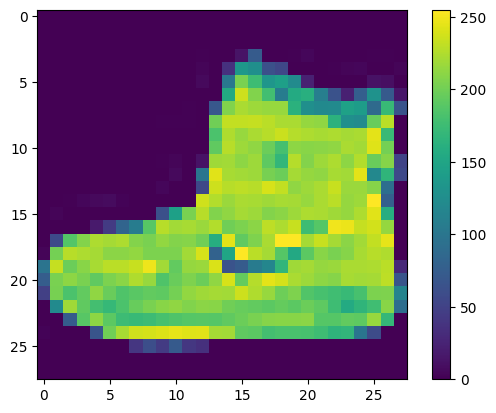

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

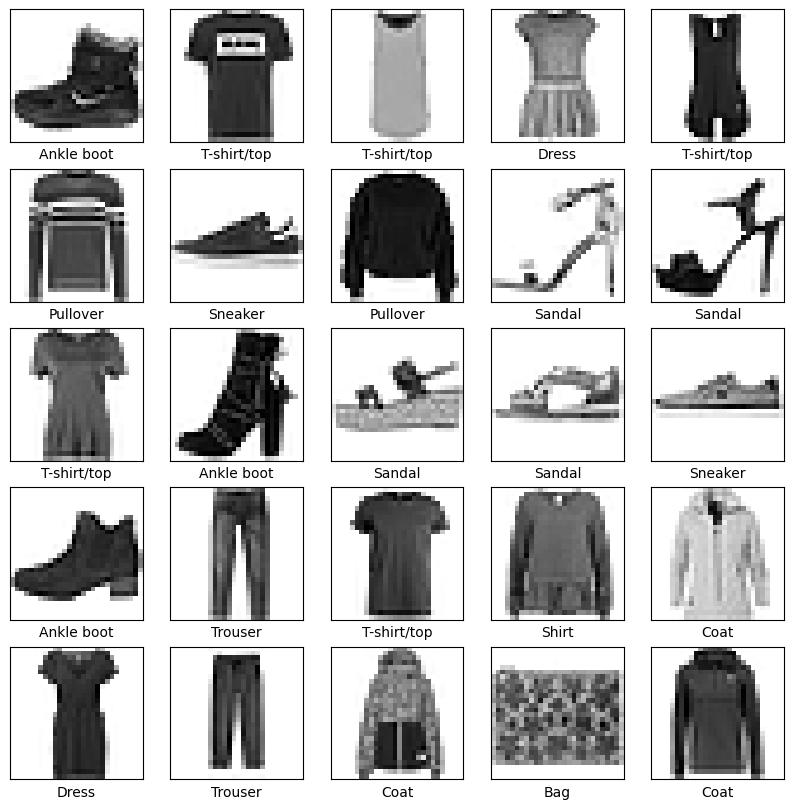

In [ ]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Build the model
Building the neural network requires configuring the layers of the model, then compiling the model.

Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape = (28, 28)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(10)])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
Optimizer —This is how the model is updated based on the data it sees and its loss function.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics= ['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4998 - accuracy: 0.8253
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3778 - accuracy: 0.8638
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3393 - accuracy: 0.8763
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3139 - accuracy: 0.8848
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2974 - accuracy: 0.8905
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2815 - accuracy: 0.8964
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2704 - accuracy: 0.9002
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2586 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2501 - accuracy: 0.9076
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.239

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3573 - accuracy: 0.8772 - 778ms/epoch - 2ms/step

Test accuracy: 0.8772000074386597


In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [ ]:
predictions[0]

array([8.4266030e-06, 8.4086809e-09, 1.7070510e-08, 2.5154065e-11,
       3.4118173e-07, 1.7464892e-03, 2.4611750e-06, 1.8901257e-02,
       1.5632570e-07, 9.7934091e-01], dtype=float32)

In [ ]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label: color = 'blue'
  else: color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), class_names[true_label]), color = color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

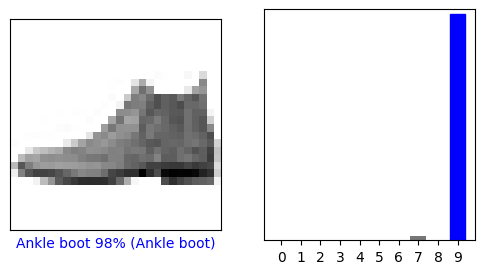

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

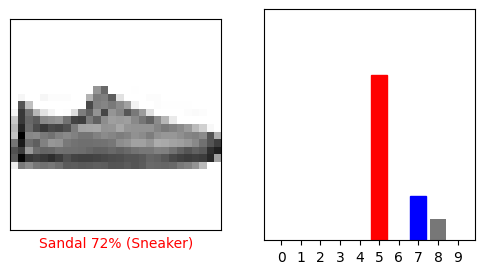

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

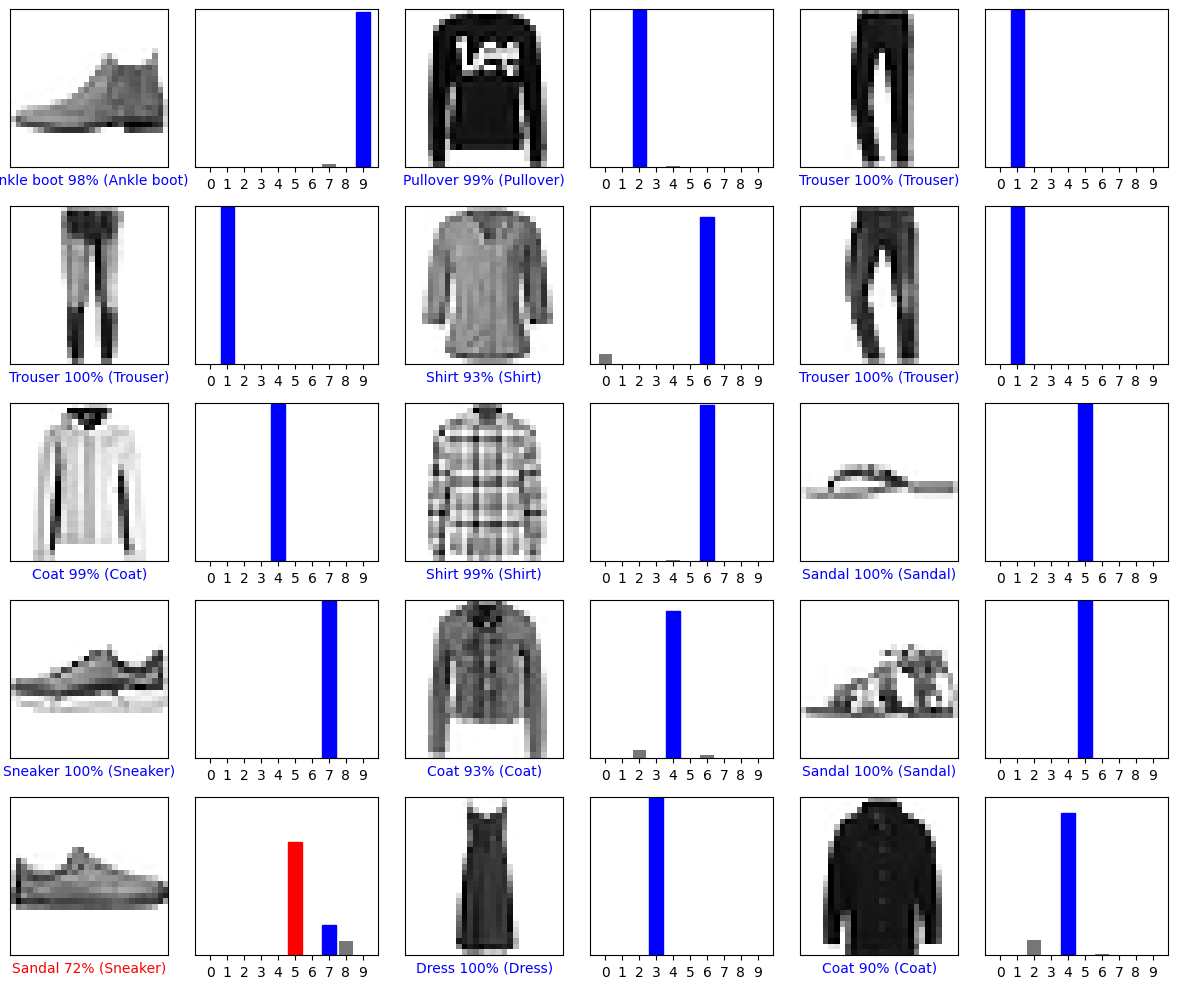

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 17ms/step
[[5.2556399e-05 7.0871364e-11 9.9346465e-01 3.6185128e-11 5.9237480e-03
  1.0842216e-12 5.5904483e-04 2.2907078e-17 7.6180564e-09 1.2212581e-18]]


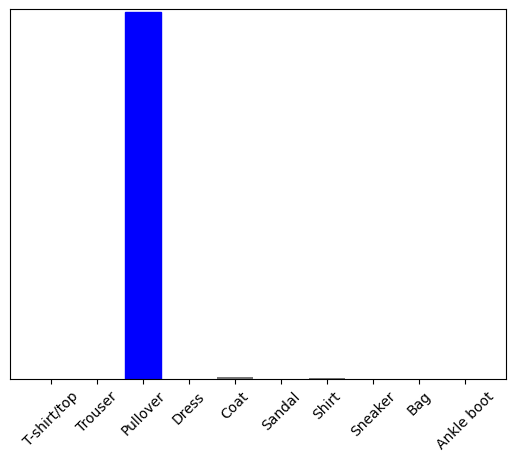

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [ ]:
np.argmax(predictions_single[0])

2